In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import Isomap
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR,AutoReg
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy as sp
nlps = sp.load('en')
import random
plt.rc('figure',figsize=(17,13))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [2]:
r_data = pd.read_csv('/kaggle/input/reddit-vaccine-myths/reddit_vm.csv')
r_data = r_data[pd.to_datetime(r_data.timestamp).dt.year>=2021]
r_data.head(3)

title  score      id  \
0  Health Canada approves AstraZeneca COVID-19 va...      7  lt74vw   
1  COVID-19 in Canada: 'Vaccination passports' a ...      2  lsh0ij   
2  Coronavirus variants could fuel Canada's third...      6  lohlle   

                                                 url  comms_num       created  \
0  https://www.canadaforums.ca/2021/02/health-can...          0  1.614400e+09   
1  https://www.canadaforums.ca/2021/02/covid-19-i...          1  1.614316e+09   
2  https://www.canadaforums.ca/2021/02/coronaviru...          0  1.613887e+09   

  body            timestamp  
0  NaN  2021-02-27 06:33:45  
1  NaN  2021-02-26 07:11:07  
2  NaN  2021-02-21 07:50:08

In [3]:
title_data = r_data[['title','timestamp']].copy()
body_data = r_data[['body','timestamp']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()


title_data.title =title_data.title.str.lower()
body_data.body =body_data.body.str.lower()

#Remove handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
title_data.title = title_data.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))



#Remove Time From Timestamp
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
body_data.timestamp = pd.to_datetime(body_data.timestamp).dt.date

In [4]:
sid = SIA()
body_data['sentiments']           = body_data['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
body_data['Positive Sentiment']   = body_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
body_data['Neutral Sentiment']    = body_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
body_data['Negative Sentiment']   = body_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

body_data.drop(columns=['sentiments'],inplace=True)


title_data['sentiments']           = title_data['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
title_data['Positive Sentiment']   = title_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
title_data['Neutral Sentiment']    = title_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
title_data['Negative Sentiment']   = title_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

title_data.drop(columns=['sentiments'],inplace=True)

In [5]:
body_data['# Of Words']          = body_data['body'].apply(lambda x: len(x.split(' ')))
body_data['# Of StopWords']      = body_data['body'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
body_data['Average Word Length'] = body_data['body'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))

title_data['# Of Words']          = title_data['title'].apply(lambda x: len(x.split(' ')))
title_data['# Of StopWords']      = title_data['title'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
title_data['Average Word Length'] = title_data['title'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))

In [6]:
title_data['# Of Times Currency Was Mentioned']          = title_data['title'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'MONEY' ]))
title_data['# Of Organizations Mentioned']           = title_data['title'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'ORG' ]))

print('Processed Title DataFrame')
body_data['# Of Times Currency Was Mentioned']          = body_data['body'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'MONEY' ]))
body_data['# Of Organizations Mentioned']           = body_data['body'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'ORG' ]))
print('Processed Body DataFrame')

Processed Title DataFrame
Processed Body DataFrame


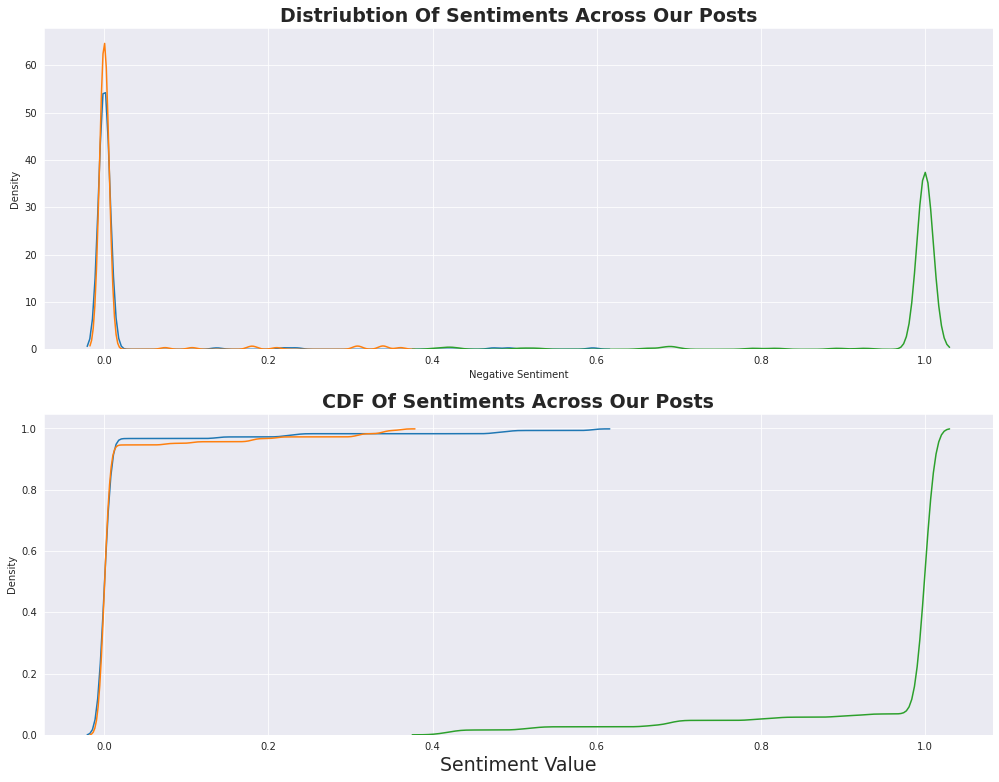

In [7]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(title_data['Negative Sentiment'],bw_method=0.1)
sns.kdeplot(title_data['Positive Sentiment'],bw_method=0.1)
sns.kdeplot(title_data['Neutral Sentiment'],bw_method=0.1)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(title_data['Negative Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(title_data['Positive Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(title_data['Neutral Sentiment'],bw_method=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

In [8]:
#Sorting And Feature Engineering
f_data = title_data.sort_values(by='timestamp')
ft_data=f_data.copy()
ft_data = ft_data.rename(columns={'timestamp':'date'})
ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1

In [9]:
f_data=f_data.reset_index().drop(columns=['index'])
f_data = f_data.rename(columns={'timestamp':'date'})

partitions = []
partitions.append(f_data.loc[44:np.round(len(f_data)/3,0)-1,:])
partitions.append(f_data.loc[np.round(len(f_data)/3,0):2*int(len(f_data)/3)-1,:])
partitions.append(f_data.loc[2*np.round(len(f_data)/3,0):3*int(len(f_data)/3)-1,:])



neg_part_means =[]
neg_part_std   =[]
pos_part_means =[]
pos_part_std   =[]
for part in partitions:
    neg_part_means.append(part['Negative Sentiment'].mean())
    neg_part_std.append(part['Negative Sentiment'].std())
    pos_part_means.append(part['Positive Sentiment'].mean())
    pos_part_std.append(part['Positive Sentiment'].std())
    
res_df = pd.DataFrame({'Positive Sentiment Mean':pos_part_means,'Negative Sentiment Mean':neg_part_means,'Positive Sentiment SD':pos_part_std,'Negative Sentiment SD':neg_part_std},
                     index = [f'Partition_{i}' for i in range(1,4)])


def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition_1_Mean'] == temp['Partition_2_Mean'])
    m2 = (temp['Partition_1_SD'] == temp['Partition_2_SD'])
    m3 = (temp['Partition_1_Mean'] < temp['Partition_2_Mean']+3) & (temp['Partition_1_Mean'] > temp['Partition_2_Mean']-3)
    m4 = (temp['Partition_1_SD'] < temp['Partition_2_SD']+3) & (temp['Partition_1_SD'] > temp['Partition_2_SD']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition_1_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_Mean'])

    df1['Partition_1_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_SD'])

    return df1



#res_df.style.apply(highlight_greater,axis=None)
res_df = res_df.T
res_df = pd.DataFrame(res_df.values,columns=res_df.columns,index=['Positive Sentiment','Negative Sentiment','Positive Sentiment','Negative Sentiment'])
res_df = pd.concat([res_df.iloc[:2,:],res_df.iloc[2:,:]],axis=1)
res_df.columns = ['Partition_1_Mean','Partition_2_Mean','Partition_3_Mean','Partition_1_SD','Partition_2_SD','Partition_3_SD']
res_df.style.apply(highlight_greater,axis=None)

In [10]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('Observed Pos', 'Observed Neg', 'Trend Pos','Trend Neg','Seasonal Pos','Seasonal Neg','Residual Pos','Residual Neg'))
b_date_mean = ft_data.groupby(by='date').mean().reset_index()

lbl = ['Positive','Negative']

for idx,column in enumerate(['Positive Sentiment','Negative Sentiment']):
    res = seasonal_decompose(b_date_mean[column], period=5, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(lbl[idx])),
    row=1, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(lbl[idx])),
    row=2, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(lbl[idx])),
    row=3, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(lbl[idx])),
    row=4, col=idx+1)
            
fig.update_layout(height=600, width=900, title_text="Decomposition Of Our Sentiments into Trend,Level,Seasonality and Residuals")
fig.show()


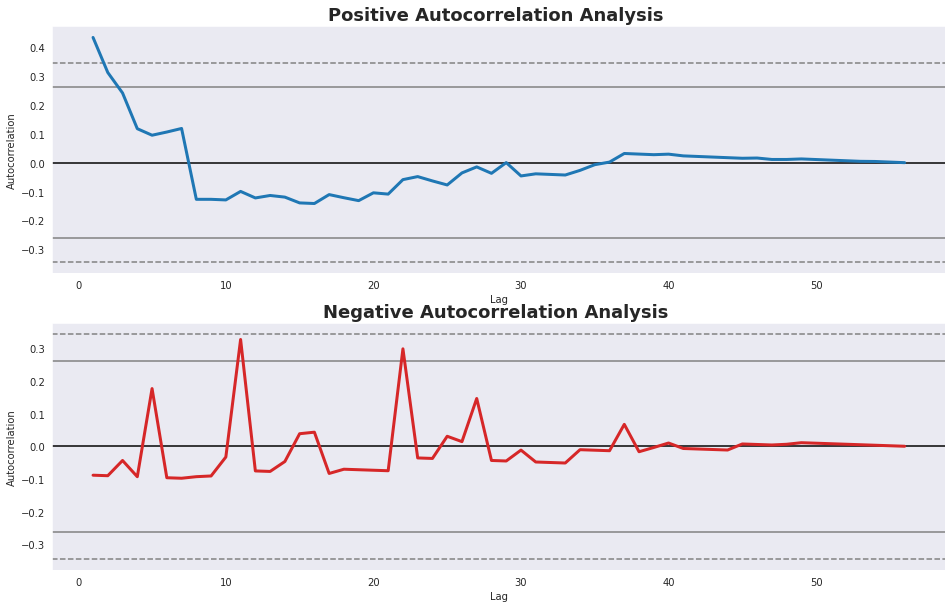

In [11]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].set_title('Positive Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Positive Sentiment'],ax=ax[0],lw=3)
ax[1].set_title('Negative Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Negative Sentiment'],ax=ax[1],color='tab:red',lw=3)
plt.show()

In [12]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =f_data.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =f_data.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()


In [13]:
b_date_count = ft_data.groupby(by='date').count().reset_index()
b_date_count = b_date_count.rename(columns={'title':'Posts Per Day'})
fig = ex.line(b_date_count,x='date',y='Posts Per Day')


fig.add_shape(type="line",
    x0=b_date_count['date'].values[0], y0=b_date_count['Negative Sentiment'].mean(), x1=b_date_count['date'].values[-1], y1=b_date_count['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
)

fig.update_traces(mode="markers+lines")
fig.update_layout(hovermode="x unified")


fig.update_layout(title='<b>Daily Post Count<b>')
fig.show()


In [14]:
NUMBER_OF_COMPONENTS = 100

CVZ = CountVectorizer()
SVD = TruncatedSVD(NUMBER_OF_COMPONENTS)

text_data = f_data.title.copy()
text_data = text_data.apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS and len(word) > 1]).strip())

stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

text_data = text_data.apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
text_data = text_data.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

C_vector = CVZ.fit_transform(text_data)


pc_matrix = SVD.fit_transform(C_vector)

evr = SVD.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance", 
    "type": "bar", 
    'y':evr}
trace2 = {
    "name": "cumulative explained variance", 
    "type": "scatter", 
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"}, 
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data=data, layout=layout)
fig.update_layout(     title='{:.2f}% of the Post Text Variance Can Be Explained Using {} Words'.format(np.sum(evr)*100,NUMBER_OF_COMPONENTS))
fig.show()

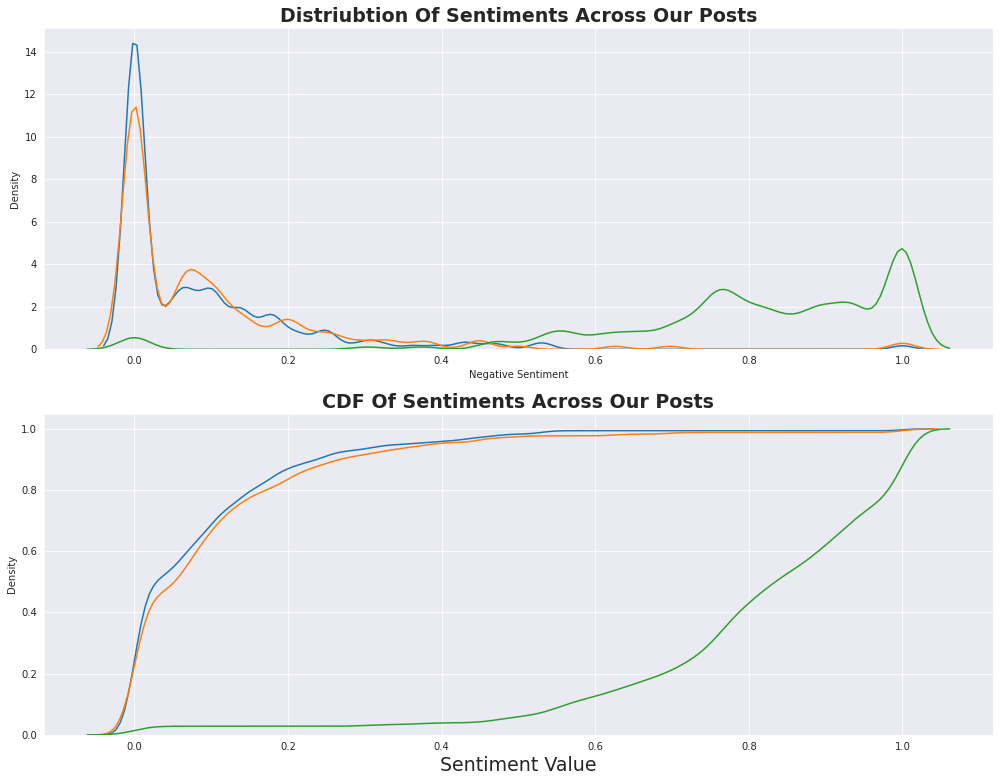

In [15]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(body_data['Negative Sentiment'],bw_method=0.1)
sns.kdeplot(body_data['Positive Sentiment'],bw_method=0.1)
sns.kdeplot(body_data['Neutral Sentiment'],bw_method=0.1)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(body_data['Negative Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(body_data['Positive Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(body_data['Neutral Sentiment'],bw_method=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

In [16]:
#Sorting And Feature Engineering
f_data = body_data.sort_values(by='timestamp')
ft_data=f_data.copy()
ft_data = ft_data.rename(columns={'timestamp':'date'})
ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1

In [17]:
f_data=f_data.reset_index().drop(columns=['index'])
f_data = f_data.rename(columns={'timestamp':'date'})

partitions = []
partitions.append(f_data.loc[44:np.round(len(f_data)/3,0)-1,:])
partitions.append(f_data.loc[np.round(len(f_data)/3,0):2*int(len(f_data)/3)-1,:])
partitions.append(f_data.loc[2*np.round(len(f_data)/3,0):3*int(len(f_data)/3)-1,:])
neg_part_means =[]
neg_part_std   =[]
pos_part_means =[]
pos_part_std   =[]
for part in partitions:
    neg_part_means.append(part['Negative Sentiment'].mean())
    neg_part_std.append(part['Negative Sentiment'].std())
    pos_part_means.append(part['Positive Sentiment'].mean())
    pos_part_std.append(part['Positive Sentiment'].std())
    
res_df = pd.DataFrame({'Positive Sentiment Mean':pos_part_means,'Negative Sentiment Mean':neg_part_means,'Positive Sentiment SD':pos_part_std,'Negative Sentiment SD':neg_part_std},
                     index = [f'Partition_{i}' for i in range(1,4)])


def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition_1_Mean'] == temp['Partition_2_Mean'])
    m2 = (temp['Partition_1_SD'] == temp['Partition_2_SD'])
    m3 = (temp['Partition_1_Mean'] < temp['Partition_2_Mean']+3) & (temp['Partition_1_Mean'] > temp['Partition_2_Mean']-3)
    m4 = (temp['Partition_1_SD'] < temp['Partition_2_SD']+3) & (temp['Partition_1_SD'] > temp['Partition_2_SD']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition_1_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_Mean'])

    df1['Partition_1_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_SD'])

    return df1



#res_df.style.apply(highlight_greater,axis=None)
res_df = res_df.T
res_df = pd.DataFrame(res_df.values,columns=res_df.columns,index=['Positive Sentiment','Negative Sentiment','Positive Sentiment','Negative Sentiment'])
res_df = pd.concat([res_df.iloc[:2,:],res_df.iloc[2:,:]],axis=1)
res_df.columns = ['Partition_1_Mean','Partition_2_Mean','Partition_3_Mean','Partition_1_SD','Partition_2_SD','Partition_3_SD']
res_df.style.apply(highlight_greater,axis=None)

In [18]:
fig = make_subplots(rows=3, cols=2)

for idx,prt in enumerate(partitions):
    by_date = prt.groupby(by='date').mean().reset_index()
    fig.add_trace(
    go.Scatter(x=by_date['date'], y=by_date['Positive Sentiment'],name=f'Positive Part {idx+1}'),
    row=idx+1, col=1)
    fig.add_trace(
    go.Scatter(x=by_date['date'], y=by_date['Negative Sentiment'],name=f'Negative Part {idx+1}'),
    row=idx+1, col=2)

fig.update_layout(height=600, width=900, title_text="Distibution Of Daily Mean Sentiments Over Our Time Line For Each Partition")
fig.show()


In [19]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('Observed Pos', 'Observed Neg', 'Trend Pos','Trend Neg','Seasonal Pos','Seasonal Neg','Residual Pos','Residual Neg'))
b_date_mean = ft_data.groupby(by='date').mean().reset_index()

lbl = ['Positive','Negative']

for idx,column in enumerate(['Positive Sentiment','Negative Sentiment']):
    res = seasonal_decompose(b_date_mean[column], period=5, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(lbl[idx])),
    row=1, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(lbl[idx])),
    row=2, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(lbl[idx])),
    row=3, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(lbl[idx])),
    row=4, col=idx+1)
            
fig.update_layout(height=600, width=900, title_text="Decomposition Of Our Sentiments into Trend,Level,Seasonality and Residuals")
fig.show()

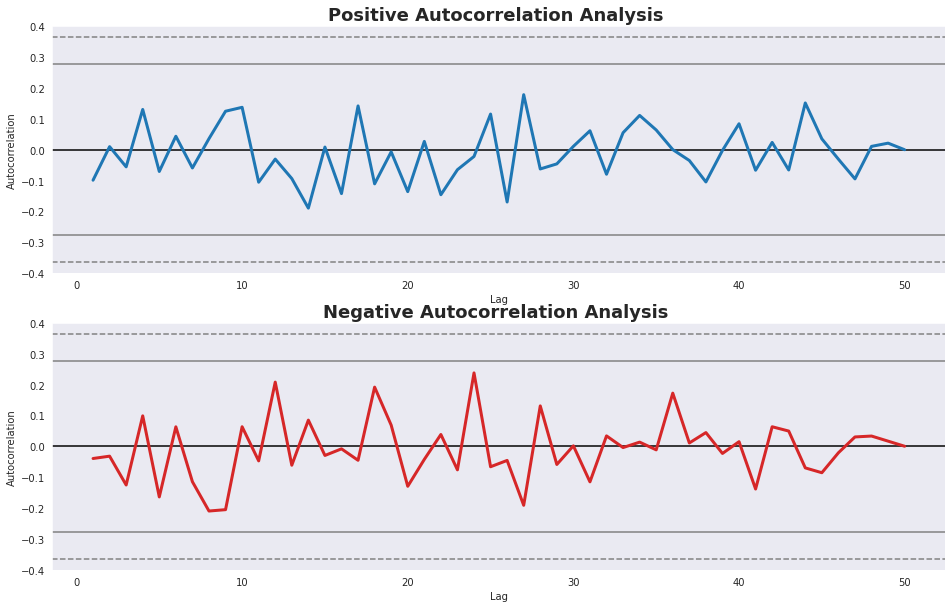

In [20]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].set_title('Positive Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Positive Sentiment'],ax=ax[0],lw=3)
ax[1].set_title('Negative Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Negative Sentiment'],ax=ax[1],color='tab:red',lw=3)
plt.show()

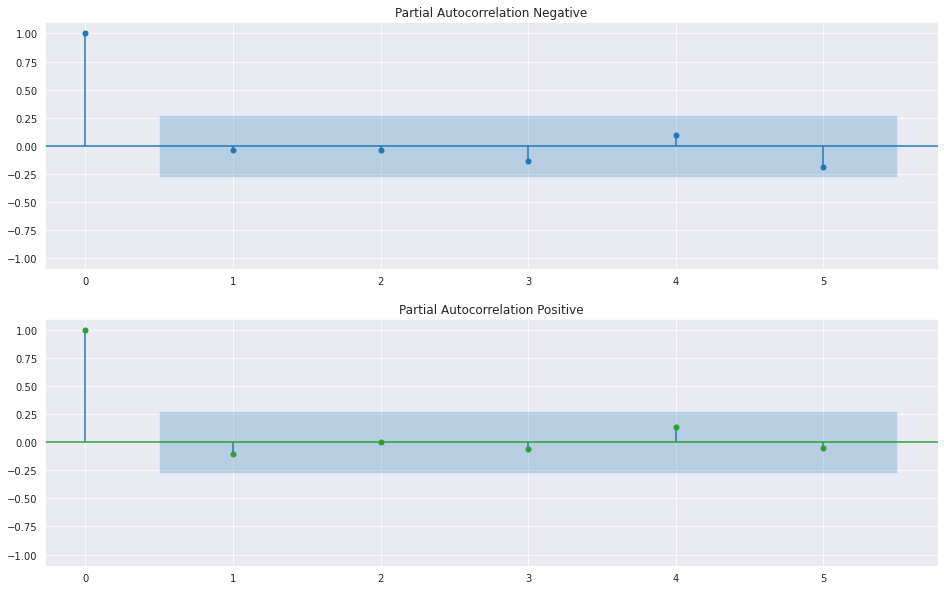

In [21]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
ax[0].set_ylim(-1.1,1.1)
ax[1].set_ylim(-1.1,1.1)


plot_pacf(b_date_mean['Negative Sentiment'],lags=5, ax=ax[0],title='Partial Autocorrelation Negative')
plot_pacf(b_date_mean['Positive Sentiment'],lags=5, ax=ax[1],color='tab:green',title='Partial Autocorrelation Positive')
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



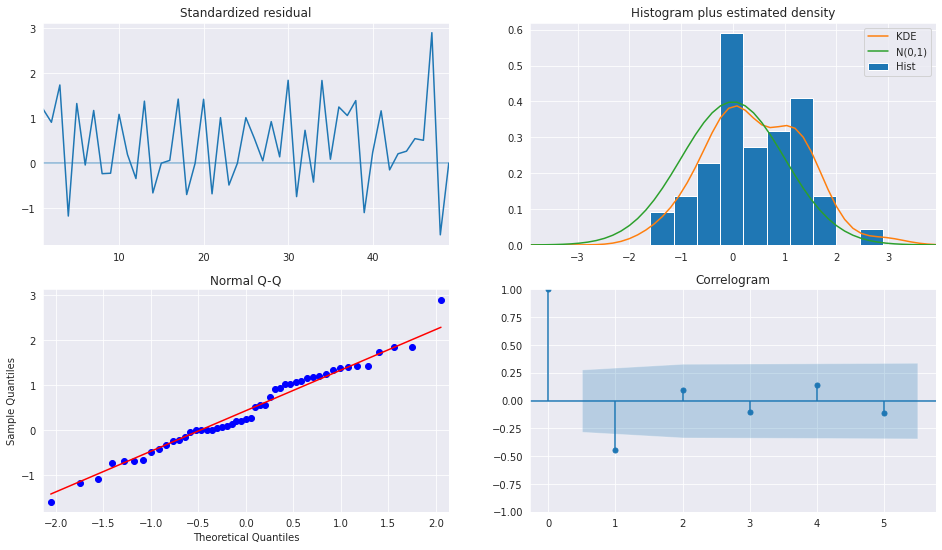

In [22]:
ar_1 = AutoReg(endog=b_date_mean['Positive Sentiment'],lags=1,trend='n',old_names=True).fit()
fig = plt.figure(figsize=(16,9))
fig = ar_1.plot_diagnostics(fig=fig, lags=5)

In [23]:
predicted_AR_1 = ar_1.predict()

output = pd.DataFrame({'Prediction':predicted_AR_1,'Actual':b_date_mean['Positive Sentiment']})

fig = make_subplots(
    rows=3, cols=2,subplot_titles=('','Actual','Predictions','Residuals'),
    vertical_spacing=0.09,
    specs=[[{"type": "table","rowspan": 3}     ,{"type": "scatter"}] ,
           [None                               ,{"type": "scatter"}]            ,           
           [None                               ,{"type": "scatter"}]                           
          ]
)

fig.add_trace(
    go.Scatter(
        x=b_date_mean.date,
        y=output["Actual"],
        mode="lines+markers",
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=b_date_mean.date,
        y=output["Prediction"],
        mode="lines+markers",
    ),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(
        x=np.arange(0,len(output["Prediction"])),
        y=output["Prediction"]-output["Actual"],
        mode="lines+markers",
    ),
    row=3, col=2
)

fig.add_trace(
    go.Table(
        header=dict(
            values=['Prediction','Actual'],
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[output[k].tolist() for k in output.columns],
            align = "left")
    ),
    row=1, col=1
)



fig.add_shape(type="line",
    x0=0, y0=(output["Prediction"]-output["Actual"]).mean(), x1=len(output["Prediction"]), y1=(output["Prediction"]-output["Actual"]).mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x3', 
        yref='y3'
)

fig.update_layout(
    height=800,
    showlegend=False,
    title_text="Prediction Evaluation",
)

fig.show()

In [24]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:     Positive Sentiment   No. Observations:                   50
Model:                     AutoReg(1)   Log Likelihood                  45.434
Method:               Conditional MLE   S.D. of innovations              0.096
Date:                Fri, 18 Jun 2021   AIC                             -4.611
Time:                        07:18:02   BIC                             -4.533
Sample:                             1   HQIC                            -4.581
                                   50                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Positive Sentiment.L1     0.4793      0.125      3.823      0.000       0.234       0.725
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.0865           +0.0000j            2.0865            0.0000
-----------------------------------------------------------------------------
"""

In [25]:
b_date_mean = ft_data.groupby(by='date').mean().reset_index()
b_date_std = ft_data.groupby(by='date').std().reset_index()


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)

    
#positive mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Positive Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean'
)




fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Negative Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)


fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()

In [26]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =f_data.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =f_data.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()

In [27]:
had_org = body_data[body_data['# Of Organizations Mentioned']>0].copy()
org_names = []
for body in had_org.body:
    org_names+=[str(tok) for tok in nlps(body).ents if tok.label_ == 'ORG' ]
org_freq=dict(nltk.FreqDist(org_names))
org_freq = {k: v for k, v in sorted(org_freq.items(), key=lambda item: item[1],reverse=True)}
top_10_org = list(org_freq.keys())[:10]
mask = []
indx = []
for idx,b in enumerate(had_org.body):
    for m in top_10_org:
        if b.find(m) !=-1:
            mask.append(m)
            indx.append(idx)
            break

top_10_org_df = had_org.iloc[indx,:].copy()
top_10_org_df['Organization'] = mask

by_org = top_10_org_df.groupby('Organization').mean().reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(x=by_org['Organization'],y=by_org['Positive Sentiment'],name='Positive Sentiment',marker_color='lightgreen'))
fig.add_trace(go.Bar(x=by_org['Organization'],y=by_org['Negative Sentiment'],name='Negative Sentiment',marker_color='salmon'))
fig.update_layout(barmode='group',title='Average Sentiment Intensity In The Top 10 Discussed Organization')

In [28]:
fig = go.Figure()
fig.add_trace(go.Bar(x=by_org['Organization'],y=by_org['# Of Words'],name='Number Of Words',marker_color='skyblue'))
fig.add_trace(go.Bar(x=by_org['Organization'],y=by_org['# Of StopWords'],name='Number Of Stopwords',marker_color='salmon'))
fig.update_layout(barmode='group',title='Average Naive Text Attributes The Top 10 Discussed Organization')

In [29]:
top_10_text_bulk = [' '.join(top_10_org_df[top_10_org_df['Organization'] == i].body) for i in top_10_org]
top_org_freqs = []
stopwords = nltk.corpus.stopwords.words('english')
for i in top_10_text_bulk:
    freq = dict(nltk.FreqDist(i.split(' ')))
    freq = {k: v for k, v in sorted(freq.items(), key=lambda item: item[1],reverse=True)}
    freq = {k: v for k, v in freq.items() if k not in stopwords and len(k)>1}
    top_org_freqs.append(freq)

In [30]:
fig = go.Figure()

for freq,org in zip(top_org_freqs,top_10_org):
    fig.add_trace(
        go.Bar(
            x = list(freq.keys())[1:11],
            y = list(freq.values())[1:11],
            name = org
        )
    )
    

btns = []
for x,col in enumerate(top_10_org):
    bol = [False]*12
    bol[x]=True
    d = dict(label = col,
                  method = 'update',
                  args = [{'visible':bol},
                          {'title': 'Distribution Of Top 10 Words in [' +col+'] Related Posts',
                           'showlegend':True}])
    btns.append(d)
    
    
fig.update_layout(title='Distribution Of 10 Most Common Words In Different Organization Related Posts',
    updatemenus=[go.layout.Updatemenu(
        active=0,
        showactive=True,
        buttons=btns
        )
    ])

fig.update_xaxes(title_text='Word')
fig.update_yaxes(title_text='Appearances')

fig.show()

In [31]:
NUMBER_OF_COMPONENTS = 2

#Preprocessing Top10 Organization Post Bodies
text_data = top_10_org_df.body.copy()

stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()
text_data = text_data.apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
text_data = text_data.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))


#Vectorization

CVZ = CountVectorizer()
Reduction_Pipeline = Pipeline(steps=[('scale',StandardScaler(with_mean=False)),('iso',Isomap(n_components= NUMBER_OF_COMPONENTS))])


C_vector = CVZ.fit_transform(text_data)


pc_matrix = Reduction_Pipeline.fit_transform(C_vector)

In [32]:
dec_top_10_df= top_10_org_df.reset_index().copy()
temp = pd.DataFrame(pc_matrix,columns=['Dim1','Dim2'])['Dim1']
dec_top_10_df['Dim1'] = pc_matrix[:,0]
dec_top_10_df['Dim2'] = pc_matrix[:,1]
fig = ex.scatter(dec_top_10_df,x='Dim1',y='Dim2',color='Organization')
fig.update_layout(title='Vectorized Post Body Text Projected On to 2D Space Using Isomap')
fig.show()

In [33]:
DBS = DBSCAN(eps=0.8,min_samples=15)
DBS.fit(dec_top_10_df[['Dim1','Dim2']])
dec_top_10_df['Cluster']  = DBS.labels_
fig = ex.scatter(dec_top_10_df,x='Dim1',y='Dim2',color='Cluster')
fig.update_layout(title='Using DBSCAN To Cluster All Anomalies Which Deviate From The Main Span')
fig.show()

In [34]:
anam = dec_top_10_df.query('Cluster == -1')
fig = ex.pie(anam,names='Organization')
fig.update_layout(title='Proportion Each Organization Appears As An Anomaly')
fig.show()

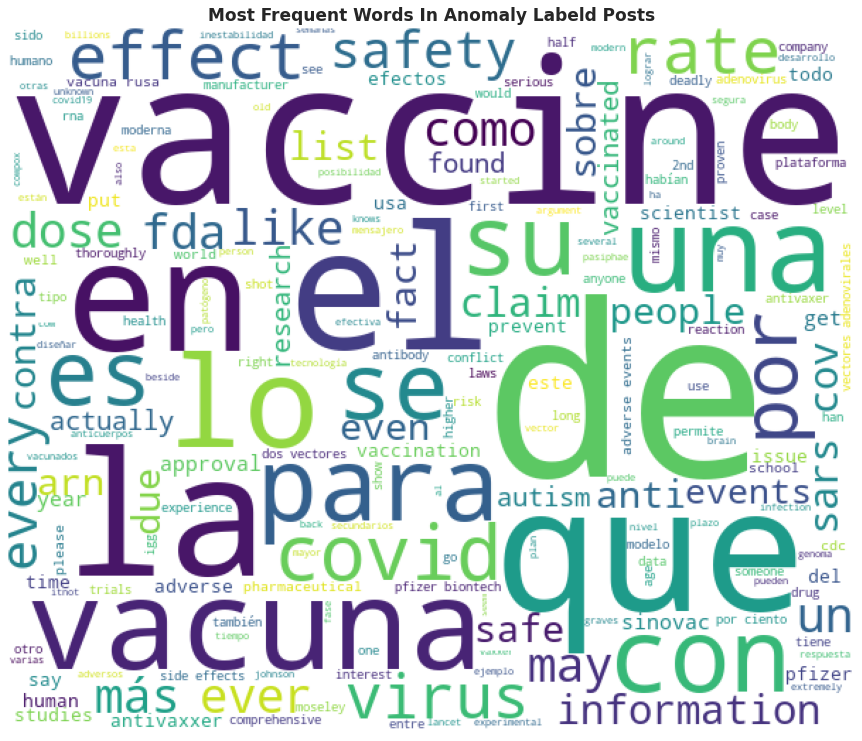

In [35]:
anam_text = ' '.join(anam.body)
awc = WordCloud(width=600,height=500,background_color='white',stopwords=stopwords).generate(anam_text)

plt.title('Most Frequent Words In Anomaly​ Labeld Posts',fontsize=17,fontweight='bold')
plt.imshow(awc)
plt.axis('off')
plt.show()


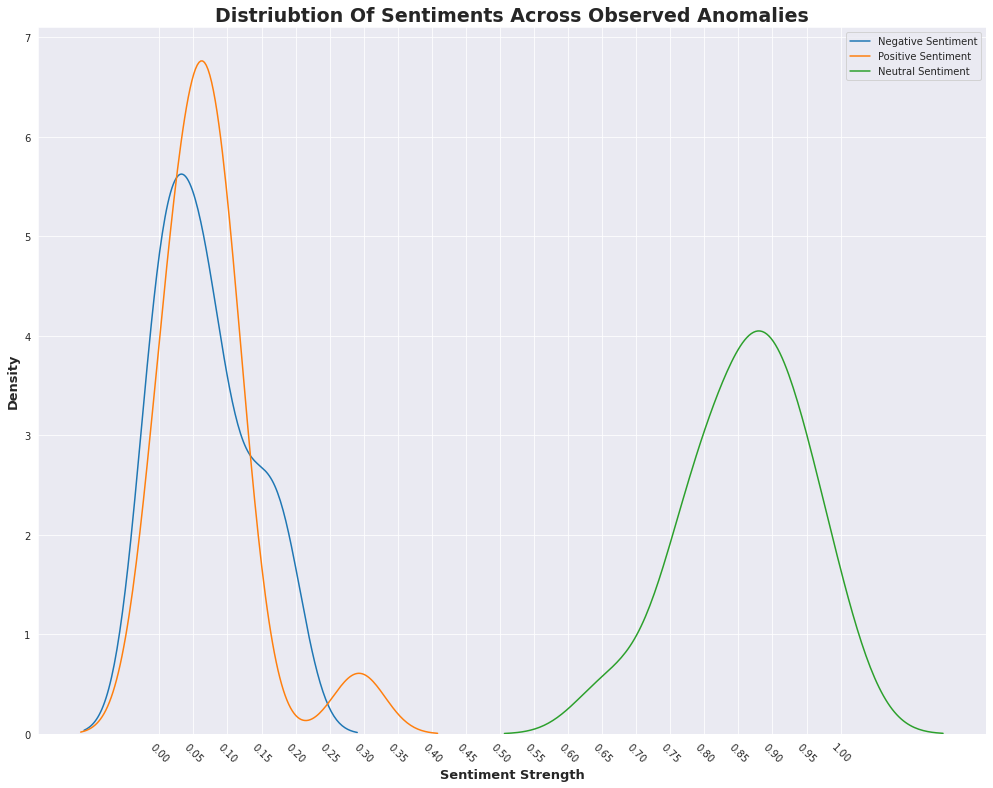

In [36]:
plt.title('Distriubtion Of Sentiments Across Observed Anomalies',fontsize=19,fontweight='bold')
sns.kdeplot(anam['Negative Sentiment'],label='Negative Sentiment')
sns.kdeplot(anam['Positive Sentiment'],label='Positive Sentiment')
sns.kdeplot(anam['Neutral Sentiment'],label='Neutral Sentiment')
plt.xlabel('Sentiment Strength',fontsize=13,fontweight='bold')
plt.ylabel('Density',fontsize=13,fontweight='bold')
plt.xticks(np.arange(0,1.05,0.05),rotation=-45)
plt.legend()
plt.show()

In [37]:
firt_mode = anam[anam['Negative Sentiment'].between(0,0.03)]
sec_mode = anam[anam['Negative Sentiment'].between(0.03,0.25)]

In [38]:
anam_count = anam.groupby('timestamp').count().reset_index()
fig = ex.line(anam_count,x='timestamp',y='body')
fig.update_layout(title='Number Of Anomalies Observed Per Time-Stamp')
fig.show()

In [39]:
import pymc3 as pm

anam_count_observed = anam_count['index']
N = 15000
with pm.Model():
    
    LAMB = pm.Uniform('lambda',0,10)
    
    observed = pm.Poisson('obs',LAMB,observed=anam_count_observed)
    
    step = pm.Metropolis()
    trace = pm.sample(N,step=step)
    burned_trace = trace[int(0.8 * N):]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.



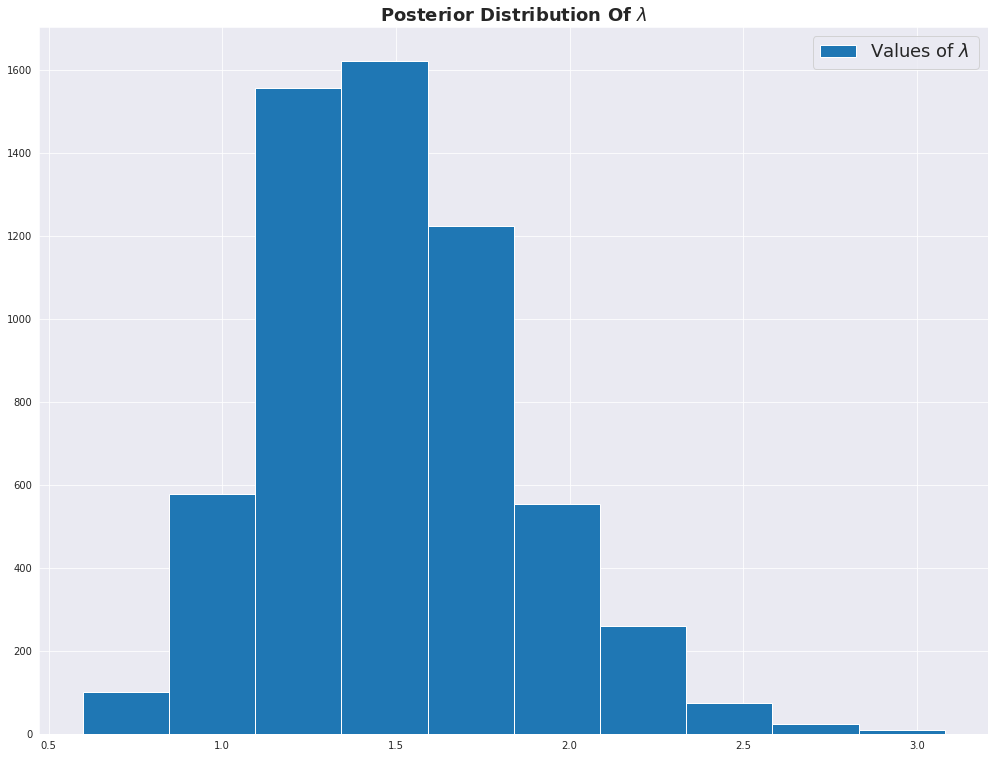

In [40]:
plt.title('Posterior Distribution Of $\lambda$',fontsize=18,fontweight='bold')
plt.hist(burned_trace['lambda'],label='Values of $\lambda$ ')
plt.legend(prop=dict(size=18))
plt.show()

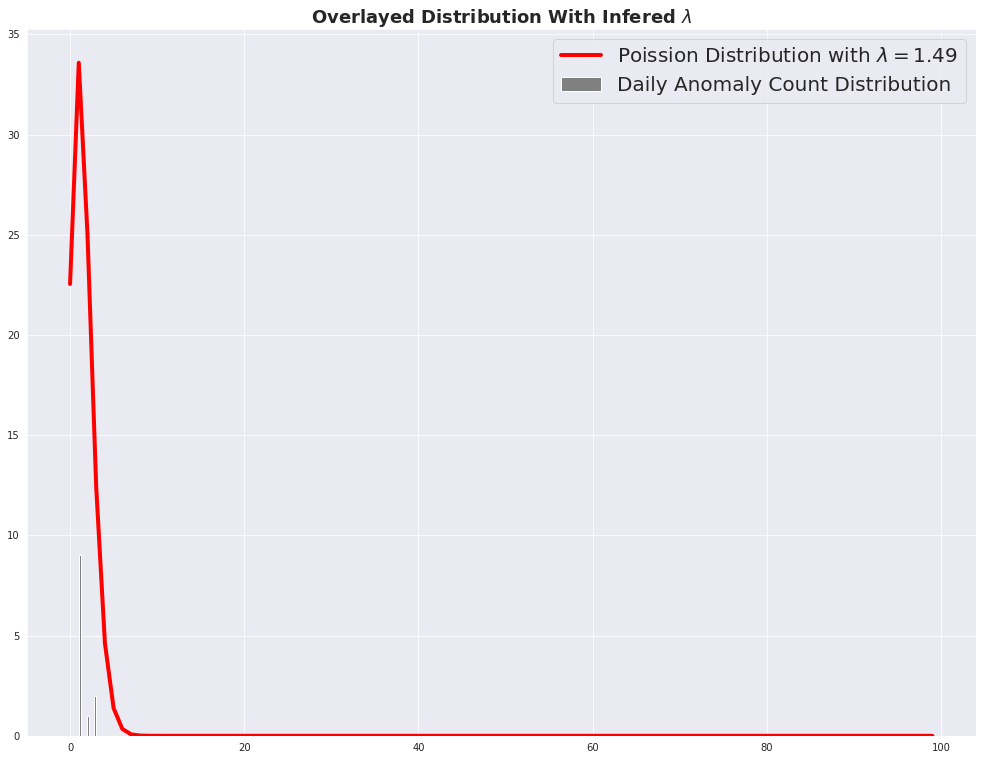

In [41]:
import scipy.stats as stats
plt.title('Overlayed Distribution With Infered $\lambda$',fontsize=18,fontweight='bold')
RANGE = np.arange(0,100,1)
mean_l = np.mean(burned_trace['lambda'])
plt.hist(anam_count_observed,color='grey',label='Daily Anomaly Count Distribution')
plt.plot(RANGE,stats.poisson.pmf(RANGE,mu=np.mean(burned_trace['lambda']))*100,'r-',lw=4,label=f'Poission Distribution with $\lambda = {np.round(mean_l,2)}$')
plt.legend(prop=dict(size=20))
plt.show()

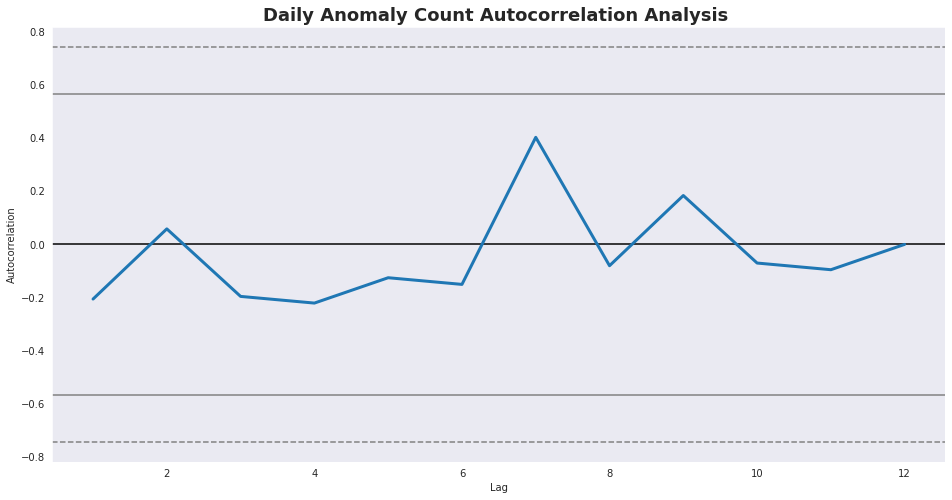

In [42]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
ax.set_title('Daily Anomaly Count Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(anam_count['body'],ax=ax,lw=3)
plt.show()

In [43]:
anam_freq = dict(nltk.FreqDist([i for i in anam_text.split(' ') if i not in stopwords and len(i)>1 ]))
anam_freq = {k: v for k, v in sorted(anam_freq.items(), key=lambda item: item[1],reverse=True)}
top_10_pos = list(anam_freq.keys())[:10]

token=nltk.word_tokenize(' '.join(anam.body))
pos_bigram=ngrams(token,2)
pos_bigram_dict = dict()
pos_trigram =ngrams(token,3)
pos_trigram = [k for k in pos_trigram if k[0] in top_10_pos]


for i in pos_bigram:
    pos_bigram_dict[i] = pos_bigram_dict.get(i,0)+1
        
pos_trigram_dict = dict()

for i in pos_trigram:
    pos_trigram_dict[i] = pos_trigram_dict.get(i,0)+1


pos_trigram_df = pd.DataFrame(random.sample(list(pos_trigram_dict.keys()),k=15),columns=['One Of Top 10 Words','Second Word','Third Word'])

def get_prob(sir):
    key = (sir['One Of Top 10 Words'],sir['Second Word'],sir['Third Word'])
    w3 = pos_trigram_dict[key]
    w2 = pos_bigram_dict[(sir['One Of Top 10 Words'],sir['Second Word'])]
    return w3/w2

pos_trigram_df['Probabilty Of Sentence'] = pos_trigram_df.apply(get_prob,axis=1)

pos_trigram_df.style.background_gradient(subset='Probabilty Of Sentence',cmap='vlag')